In [1]:
import mlflow
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact

import sys
import glob
sys.path.append('../')

from src import GLOBAL_ARTIFACTS_PATH
import matplotlib.pyplot as plt 

mlflow.set_tracking_uri('http://127.0.0.1:5000')
run_infos = [{"r_id": 'ae9ff4cde431429cb9982f4c156a6ef9', "c":'red'},{"r_id":'8485970c254f46fd9b90eca63e061fcf', "c":'blue'}]

In [2]:
def get_df_for_runs(run_infos):
    all_dfs = []
    for run_info in run_infos:
        dfs = []
        
        run = mlflow.get_run(run_info['r_id'])
        artifacts_path = GLOBAL_ARTIFACTS_PATH + '/' + '/'.join(run.info.artifact_uri.split('/')[-4:]) 

        dfs_paths = glob.glob(artifacts_path + '/*')
        for df_path in dfs_paths:
            dfs.append(pd.read_csv(df_path))
        df = pd.concat(dfs[::-1], ignore_index=True)
        df.correctness = df.correctness.astype(int)
        c_type = run.data.params['model/certainty_strategy']
        run_info["c_type"]=c_type       
        all_dfs.append([df, run_info])
        print(f'loaded {artifacts_path}')
    return all_dfs

/home/obermeier/venv/semi_supervised_certain_pseudo_labeling/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def plot_correctness(dfs, threshold):
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,10))
    legends = []
    for data in dfs: 
        legends.append(data[1]["c_type"])
        df = data[0]
        df[df.score > threshold].groupby('epoch').correctness.mean().plot.line(color=data[1]['c'], alpha=0.6, ax=ax1)
        df[df.score > threshold].groupby('epoch').correctness.count().plot.line(color=data[1]['c'], alpha=0.6, ax=ax2)
    
    f.suptitle(f'Threshold {threshold}', fontsize=16)
    ax1.set_ylabel('accuracy of pseudo-label')
    ax2.set_ylabel('Number of samples above threshold')
    ax1.legend(legends)
    ax2.legend(legends)
    f.show()
    
    

In [4]:
dfs = get_df_for_runs(run_infos)

loaded /nfs/data3/obermeier/sscpl//mlruns/2/ae9ff4cde431429cb9982f4c156a6ef9/artifacts
loaded /nfs/data3/obermeier/sscpl//mlruns/3/8485970c254f46fd9b90eca63e061fcf/artifacts


<ipython-input-3-57d0a3ee1040>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


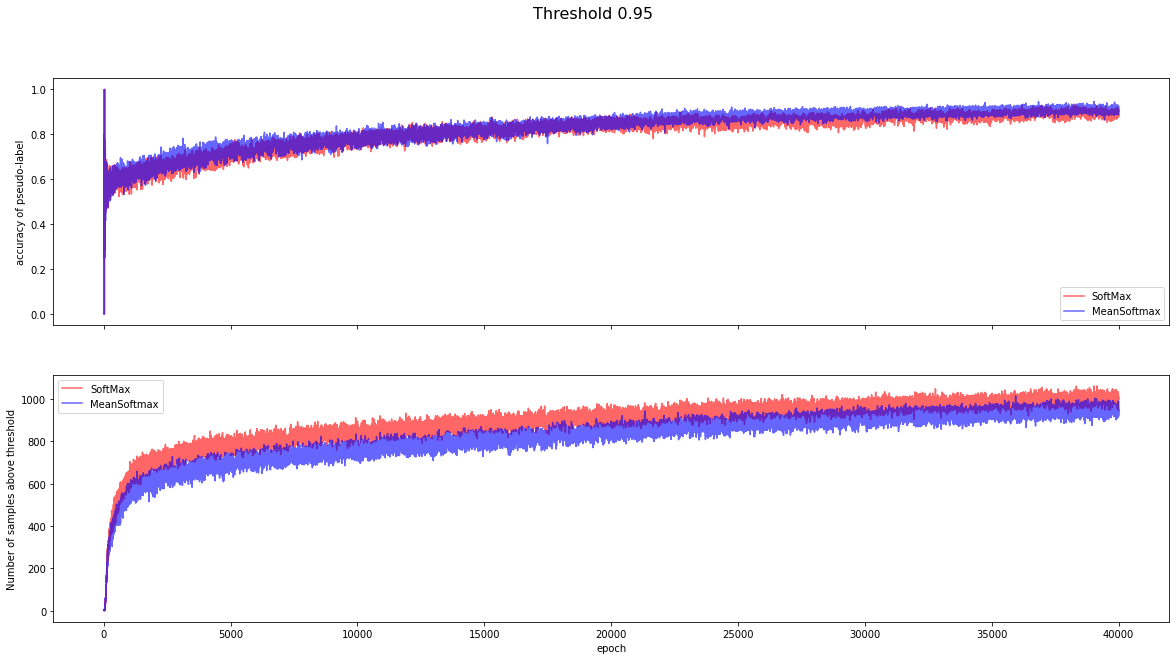

In [5]:
threshold = 0.95

plot_correctness(dfs, threshold)